In [1]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import numpy as np
from hsvi.tensorflow import Hierarchy_SVI
from hsvi.tensorflow.distributions import Normal
from hsvi.tensorflow.utils import get_next_batch,plot

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
class VAE:
    def __init__(self,x,encoder_shape,decoder_shape,learning_rate=0.001,ac_fn=tf.nn.relu):
        self.x = x
        self.encoder_shape = encoder_shape
        self.decoder_shape = decoder_shape
        self.ac_fn = ac_fn
        self.qz = self.encoder(x)
        self.tx = self.decoder(self.qz)
        self._conf_opt(learning_rate)
        
    def encoder(self,x):
        h = x
        with tf.variable_scope('global',reuse=tf.compat.v1.AUTO_REUSE):
            for i in range(len(self.encoder_shape)-1):                
                d1 = self.encoder_shape[i]
                d2 = self.encoder_shape[i+1]
                w = tf.get_variable(dtype=tf.float32, initializer=tf.random_normal([d1,d2],stddev=0.001),name='en_l'+str(i)+'_w')
                b = tf.get_variable(dtype=tf.float32, initializer=tf.random_normal([d2],stddev=0.001),name='en_l'+str(i)+'_b')
                
                if i != len(self.encoder_shape) - 2:
                    h = tf.add(tf.matmul(h,w),b)
                    h = self.ac_fn(h)
                else:
                    ### mean of encoded latent variable ###
                    mu = tf.add(tf.matmul(h,w),b)
                    ### define another output layer for standard deviation of encoded latent variables ###
                    w_s = tf.get_variable(dtype=tf.float32, initializer=tf.random_normal([d1,d2],stddev=0.001),name='en_l'+str(i)+'_w_s')
                    b_s = tf.get_variable(dtype=tf.float32, initializer=tf.random_normal([d2],stddev=0.001),name='en_l'+str(i)+'_b_s')
                    sigma = tf.nn.softplus(tf.add(tf.matmul(h,w_s),b_s))
                    
                 
        return Normal(mu, sigma)
        
         
    
    
    def decoder(self,z):
        h = z     
        with tf.variable_scope('global',reuse=tf.compat.v1.AUTO_REUSE):
            for i in range(len(self.decoder_shape)-1):                
                d1 = self.decoder_shape[i]
                d2 = self.decoder_shape[i+1]
                w = tf.get_variable(dtype=tf.float32, initializer=tf.random_normal([d1,d2],stddev=0.001),name='de_l'+str(i)+'_w')
                b = tf.get_variable(dtype=tf.float32, initializer=tf.random_normal([d2],stddev=0.001),name='de_l'+str(i)+'_b')
               
                if i != len(decoder_shape) - 2:
                    h = tf.add(tf.matmul(h,w),b)
                    h = self.ac_fn(h)
                else:
                    ### reconstruction of the data ###
                    tx = tf.nn.sigmoid(tf.add(tf.matmul(h,w),b))
        
        return tx
    
        
    def _conf_opt(self,learning_rate):
        ### config optimizer ###
        with tf.variable_scope('global'):
            step = tf.Variable(0, trainable=False, name='global_step')                                      
            self.optimizer = (tf.train.AdamOptimizer(learning_rate,beta1=0.9),step)

In [4]:
def config_inference(model,noise_std,TRAIN_SIZE,vi_type='KLqp',scale=1.,):
    
    ### config priors for latent code ###
    pz = Normal(loc=tf.zeros_like(model.qz),scale=tf.ones_like(model.qz))  
    
    ### use to compute the liklihood of raw data ###
    px = Normal(loc=model.tx, scale=noise_std)
        
    ### config variational inference ###
    inference = Hierarchy_SVI(vi_types={'global':vi_type},optimizer={'global':model.optimizer},train_size=TRAIN_SIZE,latent_vars={'global':{pz:model.qz}},data={'global':{px:model.x}})        

    return inference

In [5]:
train_size = 10000
test_size = 1000
batch_size = 128
epoch = 150
encoder_shape = [256,128]
decoder_shape = [128,256]
noise_std = 0.01

In [6]:
### load data ###
DATA_DIR = '/home/yu/gits/data/fashion/'
data = input_data.read_data_sets(DATA_DIR,one_hot=True)
X_TRAIN = data.train.images[:train_size]
X_TEST = data.test.images[:test_size]

Extracting /home/yu/gits/data/fashion/train-images-idx3-ubyte.gz
Extracting /home/yu/gits/data/fashion/train-labels-idx1-ubyte.gz
Extracting /home/yu/gits/data/fashion/t10k-images-idx3-ubyte.gz
Extracting /home/yu/gits/data/fashion/t10k-labels-idx1-ubyte.gz


In [7]:
### config net shape ###
d_dim = X_TRAIN.shape[1]
encoder_shape = [d_dim]+encoder_shape
decoder_shape = decoder_shape+[d_dim]

### config input ###
x_ph = tf.placeholder(dtype=tf.float32,shape=[None,d_dim])


In [8]:
### define model ###
model = VAE(x=x_ph,encoder_shape=encoder_shape,decoder_shape=decoder_shape)
inference = config_inference(model,noise_std,train_size)

start init hsvi
global KLqp
config optimizer in scope global


In [9]:
### train process ###
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
tf.global_variables_initializer().run(session=sess)
for e in range(epoch):
    shuffle_inds = np.arange(X_TRAIN.shape[0])
    np.random.shuffle(shuffle_inds)
    x_train = X_TRAIN[shuffle_inds]    
    ii = 0
    num_iter = int(np.ceil(x_train.shape[0]/batch_size))
    for _ in range(num_iter):
        x_batch,_,ii = get_next_batch(x_train,batch_size,ii)
        feed_dict = {x_ph:x_batch}
        info_dict = inference.update(scope='global',feed_dict=feed_dict,sess=sess)
    if (e+1)%10==0:
        print('epoch {} loss {}'.format(e+1, info_dict['loss']))

epoch 10 loss 103.25839233398438
epoch 20 loss 90.4692153930664
epoch 30 loss 70.9309310913086
epoch 40 loss 60.811466217041016
epoch 50 loss 59.81365203857422
epoch 60 loss 45.50143051147461
epoch 70 loss 45.902889251708984
epoch 80 loss 42.34739685058594
epoch 90 loss 39.21577453613281
epoch 100 loss 33.9538459777832
epoch 110 loss 33.1501579284668
epoch 120 loss 37.212440490722656
epoch 130 loss 32.199180603027344
epoch 140 loss 34.00405502319336
epoch 150 loss 33.36357116699219


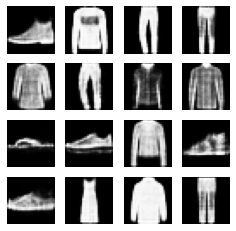

In [10]:
### plot reconstructed figure ###
fig=plot(sess.run(model.tx,feed_dict={x_ph:X_TEST[:16]}).reshape(-1,28,28))

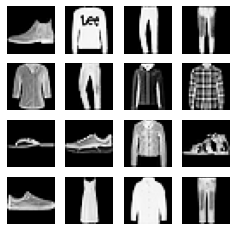

In [11]:
### plot raw figure ###
fig=plot(X_TEST[:16].reshape(-1,28,28))